In [1]:
!pip install sentence-transformers

     |████████████████████████████████| 71kB 4.3MB/s 
     |████████████████████████████████| 1.8MB 8.1MB/s 
     |████████████████████████████████| 1.2MB 44.2MB/s 
     |████████████████████████████████| 890kB 37.2MB/s 
     |████████████████████████████████| 2.9MB 45.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-cp36-none-any.whl size=103068 sha256=2b2f6f90322d0a8cefb2b10022fbaf8d7a6c3f953c1c2eaf60c148ecc7ceee25
  Stored in directory: /root/.cache/pip/wheels/3d/33/d1/5703dd56199c09d4a1b41e0c07fb4e7765a84d787cbdc48ac3
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=fdf3c6407a885c99638790c0314eeef8c870e3a0ab7d006fa4217ac07448990f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [1]:
import pandas as pd
import numpy as np
import math
import pickle
import logging
from datetime import datetime
from sentence_transformers import (SentenceTransformer, LoggingHandler, util, models,
                                   evaluation, losses, InputExample, SentencesDataset)
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, BinaryClassificationEvaluator
from torch.utils.data import DataLoader, IterableDataset
import torch

In [2]:
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [3]:
!rm -r /content/output

# Evaluate pre-trained models

In [ ]:
names = [
         'distiluse-base-multilingual-cased-v2',
         'paraphrase-xlm-r-multilingual-v1',
         'stsb-xlm-r-multilingual',
         'quora-distilbert-multilingual'
]

evaluations = [
               '/embeddings/similarity_evaluation_cds_results.csv',
               '/ir/Information-Retrieval_evaluation_czywiesz_results.csv',
               '/ir_paragraphs/Information-Retrieval_evaluation_czywiesz_par_results.csv'
]

In [ ]:
base_path = '/content/drive/MyDrive/models/Tests/'
evaluation = '/embeddings/similarity_evaluation_cds_results.csv'
results = []

for eval in evaluations:
  current_results = []
  for name in names:
    path = base_path + name + eval
    temp = pd.read_csv(path).iloc[:1]
    temp['model'] = name
    current_results.append(temp)

  current_results = pd.concat(current_results)
  current_results.drop(columns=['epoch', 'steps'], inplace=True)
  columns = current_results.columns.tolist()
  current_results = current_results[[columns[-1]] + columns[:-1]]
  current_results.reset_index(drop=True, inplace=True)

  results.append(current_results)

In [ ]:
results[0]

,model,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,distiluse-base-multilingual-cased-v2,0.878515,0.877008,0.862547,0.876435,0.859509,0.873385,0.826851,0.829585
1,paraphrase-xlm-r-multilingual-v1,0.915836,0.910637,0.908304,0.907112,0.907047,0.905628,0.877705,0.865510
2,stsb-xlm-r-multilingual,0.887779,0.885161,0.875350,0.876960,0.874208,0.876437,0.838509,0.829004
3,quora-distilbert-multilingual,0.821687,0.849722,0.841780,0.842773,0.841113,0.842188,0.786613,0.785287


In [ ]:
results[1]

,model,Accuracy@1,Accuracy@3,Accuracy@5,Accuracy@10,Precision@1,Recall@1,Precision@3,Recall@3,Precision@5,Recall@5,Precision@10,Recall@10,MRR@10,NDCG@10,MAP@100
0,distiluse-base-multilingual-cased-v2,0.644800,0.770812,0.811709,0.858626,0.644800,0.644800,0.256937,0.770812,0.162342,0.811709,0.085863,0.858626,0.716071,0.750547,0.720487
1,paraphrase-xlm-r-multilingual-v1,0.836205,0.917584,0.937305,0.958896,0.836205,0.836205,0.305861,0.917584,0.187461,0.937305,0.095890,0.958896,0.880396,0.899635,0.881870
2,stsb-xlm-r-multilingual,0.590201,0.714137,0.756487,0.808595,0.590201,0.590201,0.238046,0.714137,0.151297,0.756487,0.080859,0.808595,0.662591,0.697816,0.667771
3,quora-distilbert-multilingual,0.602034,0.708532,0.747353,0.797177,0.602034,0.602034,0.236177,0.708532,0.149471,0.747353,0.079718,0.797177,0.665448,0.697121,0.670427


In [ ]:
results[2]

,model,Accuracy@1,Accuracy@3,Accuracy@5,Accuracy@10,Precision@1,Recall@1,Precision@3,Recall@3,Precision@5,Recall@5,Precision@10,Recall@10,MRR@10,NDCG@10,MAP@100
0,distiluse-base-multilingual-cased-v2,0.551381,0.678846,0.723895,0.779946,0.551381,0.551381,0.226282,0.678846,0.144779,0.723895,0.077995,0.779946,0.625284,0.662512,0.630700
1,paraphrase-xlm-r-multilingual-v1,0.605979,0.724725,0.763546,0.809633,0.605979,0.605979,0.241575,0.724725,0.152709,0.763546,0.080963,0.809633,0.674149,0.706916,0.678707
2,stsb-xlm-r-multilingual,0.405024,0.524393,0.582935,0.646253,0.405024,0.405024,0.174798,0.524393,0.116587,0.582935,0.064625,0.646253,0.479739,0.519575,0.487758
3,quora-distilbert-multilingual,0.461491,0.578368,0.628192,0.690471,0.461491,0.461491,0.192789,0.578368,0.125638,0.628192,0.069047,0.690471,0.533318,0.570937,0.540081


# Bi-encoder - CDS

Parameters

In [ ]:
#You can specify any huggingface/transformers pre-trained model here, for example, bert-base-uncased, roberta-base, xlm-roberta-base
model_name = 'paraphrase-xlm-r-multilingual-v1'
batch_size = 16
num_epochs = 5
max_seq_length = 128
use_cuda = torch.cuda.is_available()
model_save_path = 'output/cds-bi-encoder-'+model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

Load dataset

In [ ]:
cds = pd.read_csv('/content/drive/MyDrive/Polish CDSCorpus/dataset.csv', sep='\t')
cds.head()

,ID,A,B,RE,round(RE),A_wrt_B,B_wrt_A
0,1,Zawodnik na boisku ze skórzaną rękawicą robi w...,Mężczyzna w sportowym stroju stoi na ugiętej n...,2.17,2,neutral,neutral
1,2,Zawodnik na boisku ze skórzaną rękawicą robi w...,Wykrok w przód jest robiony na piasku na boisk...,5.00,5,entailment,entailment
2,3,Zawodnik na boisku ze skórzaną rękawicą robi w...,"Mężczyzna w sportowym stroju stoi na nodze, kt...",2.50,3,neutral,neutral
3,4,Zawodnik na boisku ze skórzaną rękawicą robi w...,Chłopak w czerwonych butach stoi na boisku z u...,1.50,2,neutral,neutral
4,5,Zawodnik na boisku ze skórzaną rękawicą robi w...,Osoba wykonuje skok przez przeszkodę na jasnob...,0.00,0,neutral,neutral


Prepare input examples

In [ ]:
cds_samples = []
for index, row in cds.iterrows():
  score = float(row['RE']) / 5.0
  cds_samples.append(InputExample(texts=[row['A'], row['B']], label=score))

Divide examples into dev and train sets

In [ ]:
dev_samples = cds_samples[:1000]
gold_samples = cds_samples[1000:]

train_dataloader = DataLoader(gold_samples, shuffle=True, batch_size=batch_size)
emb_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='cds')

Load model

In [ ]:
model = SentenceTransformer(model_name)

100%|██████████| 1.01G/1.01G [00:56<00:00, 17.9MB/s]


Train

In [ ]:
train_loss = losses.CosineSimilarityLoss(model=model)
warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1) #10% of train data for warm-up

model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=emb_evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path
          )


2021-01-24 20:09:25 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 0:
2021-01-24 20:09:29 - Cosine-Similarity :	Pearson: 0.9453	Spearman: 0.9436
2021-01-24 20:09:29 - Manhattan-Distance:	Pearson: 0.9247	Spearman: 0.9374
2021-01-24 20:09:29 - Euclidean-Distance:	Pearson: 0.9255	Spearman: 0.9389
2021-01-24 20:09:29 - Dot-Product-Similarity:	Pearson: 0.9324	Spearman: 0.9307
2021-01-24 20:09:29 - Save model to output/cds-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_20-05-32



2021-01-24 20:12:39 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 1:
2021-01-24 20:12:43 - Cosine-Similarity :	Pearson: 0.9423	Spearman: 0.9388
2021-01-24 20:12:43 - Manhattan-Distance:	Pearson: 0.9135	Spearman: 0.9304
2021-01-24 20:12:43 - Euclidean-Distance:	Pearson: 0.9153	Spearman: 0.9327
2021-01-24 20:12:43 - Dot-Product-Similarity:	Pearson: 0.9262	Spearman: 0.9257



2021-01-24 20:15:47 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 2:
2021-01-24 20:15:50 - Cosine-Similarity :	Pearson: 0.9452	Spearman: 0.9417
2021-01-24 20:15:50 - Manhattan-Distance:	Pearson: 0.9179	Spearman: 0.9341
2021-01-24 20:15:50 - Euclidean-Distance:	Pearson: 0.9194	Spearman: 0.9361
2021-01-24 20:15:50 - Dot-Product-Similarity:	Pearson: 0.9323	Spearman: 0.9313



2021-01-24 20:18:55 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 3:
2021-01-24 20:18:59 - Cosine-Similarity :	Pearson: 0.9450	Spearman: 0.9411
2021-01-24 20:18:59 - Manhattan-Distance:	Pearson: 0.9169	Spearman: 0.9333
2021-01-24 20:18:59 - Euclidean-Distance:	Pearson: 0.9182	Spearman: 0.9351
2021-01-24 20:18:59 - Dot-Product-Similarity:	Pearson: 0.9319	Spearman: 0.9307



2021-01-24 20:22:03 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 4:
2021-01-24 20:22:06 - Cosine-Similarity :	Pearson: 0.9453	Spearman: 0.9414
2021-01-24 20:22:06 - Manhattan-Distance:	Pearson: 0.9175	Spearman: 0.9333
2021-01-24 20:22:06 - Euclidean-Distance:	Pearson: 0.9188	Spearman: 0.9350
2021-01-24 20:22:06 - Dot-Product-Similarity:	Pearson: 0.9324	Spearman: 0.9313



In [ ]:
!mkdir /content/drive/MyDrive/models/cds-bi-encoder
!cp -r /content/output/cds-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_20-05-32 /content/drive/MyDrive/models/cds-bi-encoder

In [ ]:
results = pd.read_csv('/content/drive/MyDrive/models/cds-bi-encoder/cds-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_20-05-32/similarity_evaluation_cds_results.csv')
results

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,-1,0.945262,0.943640,0.925536,0.938948,0.924652,0.937446,0.932375,0.930739
1,1,-1,0.942300,0.938838,0.915326,0.932702,0.913458,0.930382,0.926201,0.925722
2,2,-1,0.945187,0.941700,0.919394,0.936077,0.917929,0.934123,0.932308,0.931346
3,3,-1,0.944985,0.941135,0.918172,0.935126,0.916880,0.933302,0.931915,0.930736
4,4,-1,0.945293,0.941413,0.918752,0.935038,0.917464,0.933323,0.932372,0.931269


Evaluate on InformationRetrieval

In [ ]:
full = pd.read_csv('/content/drive/MyDrive/czywieszki/answers.csv')
full.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
full.head()

,id,url,title,text,question,sentence,answer
0,2070375,http://pl.wikipedia.org/wiki/?curid=2070375,R136a1,R136a1 – gwiazda Wolfa-Rayeta typu widmowego W...,gdzie zaobserwowano najmasywniejszą znaną gwia...,['R136a1 – gwiazda Wolfa-Rayeta typu widmowego...,Na uzyskanych dzięki niemu zdjęciach można był...
1,2070656,http://pl.wikipedia.org/wiki/?curid=2070656,Apoteoza wojny,"Apoteoza wojny (oryg. ros. Апофеоз войны, ""Apo...",komu Wasilij Wierieszczagin zadedykował swój o...,"['Апофеоз войны, ""Apofieoz wojny"") – obraz Was...","Апофеоз войны, ""Apofieoz wojny"") – obraz Wasil..."
2,2070790,http://pl.wikipedia.org/wiki/?curid=2070790,Widzenie chłopca Bartłomieja,"Widzenie chłopca Bartłomieja (oryg. ros. ""Виде...",który święty prawosławny został ukazany na obr...,"['""Видение отроку Варфоломею"") – obraz Michaił...",Niestierow pragnął swoimi dziełami oddać hołd ...
3,2071346,http://pl.wikipedia.org/wiki/?curid=2071346,Cangjang Gjaco,Cangjang Gjaco (tyb. ཚང་དབྱངས་རྒྱ་མཚོ་ Wylie: ...,któremu dalajlamie przypisuje się nieśmierteln...,"['ཚང་དབྱངས་རྒྱ་མཚོ་ Wylie: ""tshang-dbyangs-rgy...",Wśród świeckich tybetańskich rozpowszechnione ...
4,2071390,http://pl.wikipedia.org/wiki/?curid=2071390,Wojna erytrejsko-etiopska,Wojna erytrejsko-etiopska trwała w latach 1998...,jakie były skutki wojny erytrejsko-etiopskiej?,['Wojna erytrejsko-etiopska trwała w latach 19...,W wyniku działań wojsk etiopskich do przesiedl...


Prepare input examples

In [ ]:
questions = full['question'].tolist()
answers = full['answer'].tolist()

Divide examples into dev and train sets

In [ ]:
dev_questions, dev_answers = questions[4000:], answers[4000:]

In [ ]:
dev_queries = {}
dev_corpus = {}
dev_rel_docs = {}

for i in range(len(dev_questions)):
  idx = str(i)
  dev_queries[idx] = dev_questions[i]
  dev_corpus[idx] = dev_answers[i]
  dev_rel_docs[idx] = {idx}

In [ ]:
ir_evaluator = evaluation.InformationRetrievalEvaluator(dev_queries, dev_corpus, dev_rel_docs, name='czywiesz')

In [ ]:
output_path = '/content/drive/MyDrive/models/cds-bi-encoder/cds-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_20-05-32/Information-Retrieval_evaluation_czywiesz_results.csv'
model.evaluate(ir_evaluator, output_path=output_path)

2021-01-24 21:41:33 - Information Retrieval Evaluation on czywiesz dataset:
2021-01-24 21:41:38 - Accuracy@1: 93.51%
2021-01-24 21:41:38 - Accuracy@3: 96.45%
2021-01-24 21:41:38 - Accuracy@5: 97.80%
2021-01-24 21:41:38 - Accuracy@10: 98.65%
2021-01-24 21:41:38 - Precision@1: 93.51%
2021-01-24 21:41:38 - Precision@3: 32.15%
2021-01-24 21:41:38 - Precision@5: 19.56%
2021-01-24 21:41:38 - Precision@10: 9.87%
2021-01-24 21:41:38 - Recall@1: 93.51%
2021-01-24 21:41:38 - Recall@3: 96.45%
2021-01-24 21:41:38 - Recall@5: 97.80%
2021-01-24 21:41:38 - Recall@10: 98.65%
2021-01-24 21:41:38 - MRR@10: 0.9531
2021-01-24 21:41:38 - NDCG@10: 0.9613
2021-01-24 21:41:38 - MAP@100: 0.9534
2021-01-24 21:41:38 - Queries: 817
2021-01-24 21:41:38 - Corpus: 817



0.9534039603220448

Final results

In [ ]:
results = pd.read_csv('/content/drive/MyDrive/models/cds-bi-encoder/cds-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_20-05-32/similarity_evaluation_cds_results.csv')
results

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,-1,0.945262,0.943640,0.925536,0.938948,0.924652,0.937446,0.932375,0.930739
1,1,-1,0.942300,0.938838,0.915326,0.932702,0.913458,0.930382,0.926201,0.925722
2,2,-1,0.945187,0.941700,0.919394,0.936077,0.917929,0.934123,0.932308,0.931346
3,3,-1,0.944985,0.941135,0.918172,0.935126,0.916880,0.933302,0.931915,0.930736
4,4,-1,0.945293,0.941413,0.918752,0.935038,0.917464,0.933323,0.932372,0.931269


In [ ]:
results = pd.read_csv('/content/drive/MyDrive/models/cds-bi-encoder/cds-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_20-05-32/Information-Retrieval_evaluation_czywiesz_results.csv/Information-Retrieval_evaluation_czywiesz_results.csv')
results

,epoch,steps,Accuracy@1,Accuracy@3,Accuracy@5,Accuracy@10,Precision@1,Recall@1,Precision@3,Recall@3,Precision@5,Recall@5,Precision@10,Recall@10,MRR@10,NDCG@10,MAP@100
0,-1,-1,0.935129,0.964504,0.977968,0.986536,0.935129,0.935129,0.321501,0.964504,0.195594,0.977968,0.098654,0.986536,0.95311,0.961268,0.953404


#Bi-encoder - Czy wiesz?

Parameters

In [ ]:
#You can specify any huggingface/transformers pre-trained model here, for example, bert-base-uncased, roberta-base, xlm-roberta-base
model_name = 'paraphrase-xlm-r-multilingual-v1'
batch_size = 64
num_epochs = 5
max_seq_length = 128
use_cuda = torch.cuda.is_available()
model_save_path = 'output/czywiesz-bi-encoder-'+model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

Load dataset

In [ ]:
full = pd.read_csv('/content/drive/MyDrive/czywieszki/answers.csv')
full.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
full.head()

,id,url,title,text,question,sentence,answer
0,2070375,http://pl.wikipedia.org/wiki/?curid=2070375,R136a1,R136a1 – gwiazda Wolfa-Rayeta typu widmowego W...,gdzie zaobserwowano najmasywniejszą znaną gwia...,['R136a1 – gwiazda Wolfa-Rayeta typu widmowego...,Na uzyskanych dzięki niemu zdjęciach można był...
1,2070656,http://pl.wikipedia.org/wiki/?curid=2070656,Apoteoza wojny,"Apoteoza wojny (oryg. ros. Апофеоз войны, ""Apo...",komu Wasilij Wierieszczagin zadedykował swój o...,"['Апофеоз войны, ""Apofieoz wojny"") – obraz Was...","Апофеоз войны, ""Apofieoz wojny"") – obraz Wasil..."
2,2070790,http://pl.wikipedia.org/wiki/?curid=2070790,Widzenie chłopca Bartłomieja,"Widzenie chłopca Bartłomieja (oryg. ros. ""Виде...",który święty prawosławny został ukazany na obr...,"['""Видение отроку Варфоломею"") – obraz Michaił...",Niestierow pragnął swoimi dziełami oddać hołd ...
3,2071346,http://pl.wikipedia.org/wiki/?curid=2071346,Cangjang Gjaco,Cangjang Gjaco (tyb. ཚང་དབྱངས་རྒྱ་མཚོ་ Wylie: ...,któremu dalajlamie przypisuje się nieśmierteln...,"['ཚང་དབྱངས་རྒྱ་མཚོ་ Wylie: ""tshang-dbyangs-rgy...",Wśród świeckich tybetańskich rozpowszechnione ...
4,2071390,http://pl.wikipedia.org/wiki/?curid=2071390,Wojna erytrejsko-etiopska,Wojna erytrejsko-etiopska trwała w latach 1998...,jakie były skutki wojny erytrejsko-etiopskiej?,['Wojna erytrejsko-etiopska trwała w latach 19...,W wyniku działań wojsk etiopskich do przesiedl...


Prepare input examples

In [ ]:
questions = full['question'].tolist()
answers = full['answer'].tolist()

Divide examples into dev and train sets

In [ ]:
train_questions, dev_questions = questions[:4000], questions[4000:]
train_answers, dev_answers = answers[:4000], answers[4000:]

In [ ]:
train_samples = []
for q, a in zip(train_questions, train_answers):
  sample = InputExample(texts=[q, a])
  train_samples.append(sample)

In [ ]:
dev_queries = {}
dev_corpus = {}
dev_rel_docs = {}

for i in range(len(dev_questions)):
  idx = str(i)
  dev_queries[idx] = dev_questions[i]
  dev_corpus[idx] = dev_answers[i]
  dev_rel_docs[idx] = {idx}

In [ ]:
train_dataloader = DataLoader(train_samples, batch_size=batch_size)
ir_evaluator = evaluation.InformationRetrievalEvaluator(dev_queries, dev_corpus, dev_rel_docs, name='czywiesz')

Prepare additional dev set

In [ ]:
cds = pd.read_csv('/content/drive/MyDrive/Polish CDSCorpus/dataset_1000.csv', sep='\t')
cds.head()

,ID,A,B,RE,round(RE),A_wrt_B,B_wrt_A
0,1,Zawodnik na boisku ze skórzaną rękawicą robi w...,Mężczyzna w sportowym stroju stoi na ugiętej n...,2.17,2,neutral,neutral
1,2,Zawodnik na boisku ze skórzaną rękawicą robi w...,Wykrok w przód jest robiony na piasku na boisk...,5.00,5,entailment,entailment
2,3,Zawodnik na boisku ze skórzaną rękawicą robi w...,"Mężczyzna w sportowym stroju stoi na nodze, kt...",2.50,3,neutral,neutral
3,4,Zawodnik na boisku ze skórzaną rękawicą robi w...,Chłopak w czerwonych butach stoi na boisku z u...,1.50,2,neutral,neutral
4,5,Zawodnik na boisku ze skórzaną rękawicą robi w...,Osoba wykonuje skok przez przeszkodę na jasnob...,0.00,0,neutral,neutral


In [ ]:
cds_samples = []
for index, row in cds.iterrows():
  score = float(row['RE']) / 5.0
  cds_samples.append(InputExample(texts=[row['A'], row['B']], label=score))

In [ ]:
emb_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(cds_samples, name='cds')

Load model

In [ ]:
model = SentenceTransformer(model_name)

2021-01-24 21:20:29 - Load pretrained SentenceTransformer: paraphrase-xlm-r-multilingual-v1
2021-01-24 21:20:29 - Did not find folder paraphrase-xlm-r-multilingual-v1
2021-01-24 21:20:29 - Try to download model from server: https://sbert.net/models/paraphrase-xlm-r-multilingual-v1.zip
2021-01-24 21:20:29 - Load SentenceTransformer from folder: /root/.cache/torch/sentence_transformers/sbert.net_models_paraphrase-xlm-r-multilingual-v1
2021-01-24 21:20:37 - Use pytorch device: cuda


Train

In [ ]:
train_loss = losses.MultipleNegativesRankingLoss(model=model)
warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1) #10% of train data for warm-up

model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=emb_evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path,
          use_amp=True
          )


2021-01-24 21:21:28 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 0:
2021-01-24 21:21:32 - Cosine-Similarity :	Pearson: 0.9146	Spearman: 0.9210
2021-01-24 21:21:32 - Manhattan-Distance:	Pearson: 0.9074	Spearman: 0.9186
2021-01-24 21:21:32 - Euclidean-Distance:	Pearson: 0.9085	Spearman: 0.9202
2021-01-24 21:21:32 - Dot-Product-Similarity:	Pearson: 0.8974	Spearman: 0.9009
2021-01-24 21:21:32 - Save model to output/czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22



2021-01-24 21:22:27 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 1:
2021-01-24 21:22:30 - Cosine-Similarity :	Pearson: 0.9180	Spearman: 0.9242
2021-01-24 21:22:30 - Manhattan-Distance:	Pearson: 0.9136	Spearman: 0.9233
2021-01-24 21:22:30 - Euclidean-Distance:	Pearson: 0.9149	Spearman: 0.9244
2021-01-24 21:22:30 - Dot-Product-Similarity:	Pearson: 0.8964	Spearman: 0.8989
2021-01-24 21:22:30 - Save model to output/czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22



2021-01-24 21:23:24 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 2:
2021-01-24 21:23:28 - Cosine-Similarity :	Pearson: 0.9192	Spearman: 0.9250
2021-01-24 21:23:28 - Manhattan-Distance:	Pearson: 0.9141	Spearman: 0.9241
2021-01-24 21:23:28 - Euclidean-Distance:	Pearson: 0.9151	Spearman: 0.9255
2021-01-24 21:23:28 - Dot-Product-Similarity:	Pearson: 0.8977	Spearman: 0.9004
2021-01-24 21:23:28 - Save model to output/czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22



2021-01-24 21:24:21 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 3:
2021-01-24 21:24:25 - Cosine-Similarity :	Pearson: 0.9183	Spearman: 0.9243
2021-01-24 21:24:25 - Manhattan-Distance:	Pearson: 0.9144	Spearman: 0.9243
2021-01-24 21:24:25 - Euclidean-Distance:	Pearson: 0.9154	Spearman: 0.9255
2021-01-24 21:24:25 - Dot-Product-Similarity:	Pearson: 0.8940	Spearman: 0.8965



2021-01-24 21:25:13 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 4:
2021-01-24 21:25:17 - Cosine-Similarity :	Pearson: 0.9180	Spearman: 0.9241
2021-01-24 21:25:17 - Manhattan-Distance:	Pearson: 0.9144	Spearman: 0.9244
2021-01-24 21:25:17 - Euclidean-Distance:	Pearson: 0.9154	Spearman: 0.9254
2021-01-24 21:25:17 - Dot-Product-Similarity:	Pearson: 0.8934	Spearman: 0.8958



In [ ]:
!mkdir /content/drive/MyDrive/models/czywiesz-bi-encoder
!cp -r /content/output/czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22 /content/drive/MyDrive/models/czywiesz-bi-encoder

Evaluate on Information Retrieval

In [ ]:
output_path = '/content/drive/MyDrive/models/czywiesz-bi-encoder/czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22/Information-Retrieval_evaluation_czywiesz_results.csv'
model.evaluate(ir_evaluator, output_path=output_path)

2021-01-24 21:38:46 - Information Retrieval Evaluation on czywiesz dataset:
2021-01-24 21:38:51 - Accuracy@1: 95.10%
2021-01-24 21:38:51 - Accuracy@3: 97.43%
2021-01-24 21:38:51 - Accuracy@5: 98.16%
2021-01-24 21:38:51 - Accuracy@10: 98.53%
2021-01-24 21:38:51 - Precision@1: 95.10%
2021-01-24 21:38:51 - Precision@3: 32.48%
2021-01-24 21:38:51 - Precision@5: 19.63%
2021-01-24 21:38:51 - Precision@10: 9.85%
2021-01-24 21:38:51 - Recall@1: 95.10%
2021-01-24 21:38:51 - Recall@3: 97.43%
2021-01-24 21:38:51 - Recall@5: 98.16%
2021-01-24 21:38:51 - Recall@10: 98.53%
2021-01-24 21:38:51 - MRR@10: 0.9635
2021-01-24 21:38:51 - NDCG@10: 0.9689
2021-01-24 21:38:51 - MAP@100: 0.9641
2021-01-24 21:38:51 - Queries: 817
2021-01-24 21:38:51 - Corpus: 817



0.9640539894434146

Final results

In [ ]:
results = pd.read_csv('/content/drive/MyDrive/models/czywiesz-bi-encoder/czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22/similarity_evaluation_cds_results.csv')
results

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,-1,0.914551,0.920961,0.908521,0.920186,0.907404,0.918576,0.897446,0.900921
1,1,-1,0.917955,0.924192,0.914883,0.924385,0.913607,0.923270,0.896433,0.898905
2,2,-1,0.919206,0.925045,0.915071,0.925480,0.914059,0.924131,0.897722,0.900415
3,3,-1,0.918261,0.924286,0.915376,0.925457,0.914384,0.924303,0.893976,0.896490
4,4,-1,0.918040,0.924109,0.915388,0.925440,0.914428,0.924409,0.893350,0.895835


In [ ]:
results = pd.read_csv('/content/drive/MyDrive/models/czywiesz-bi-encoder/czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22/Information-Retrieval_evaluation_czywiesz_results.csv/Information-Retrieval_evaluation_czywiesz_results.csv')
results

,epoch,steps,Accuracy@1,Accuracy@3,Accuracy@5,Accuracy@10,Precision@1,Recall@1,Precision@3,Recall@3,Precision@5,Recall@5,Precision@10,Recall@10,MRR@10,NDCG@10,MAP@100
0,-1,-1,0.95104,0.974296,0.98164,0.985312,0.95104,0.95104,0.324765,0.974296,0.196328,0.98164,0.098531,0.985312,0.963547,0.968931,0.964054


#Bi-encoder - Czy wiesz? - Paragraphs

Parameters

In [4]:
#You can specify any huggingface/transformers pre-trained model here, for example, bert-base-uncased, roberta-base, xlm-roberta-base
model_name = 'paraphrase-xlm-r-multilingual-v1'
batch_size = 16
num_epochs = 5
max_seq_length = 256
use_cuda = torch.cuda.is_available()
model_save_path = 'output/czywiesz-paragraphs-bi-encoder-'+model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

Load dataset

In [5]:
full = pd.read_csv('/content/drive/MyDrive/czywieszki/answers_paragraphs.csv')
full.head()

,id,url,title,text,question,answer
0,2070375,http://pl.wikipedia.org/wiki/?curid=2070375,R136a1,R136a1 – gwiazda Wolfa-Rayeta typu widmowego W...,gdzie zaobserwowano najmasywniejszą znaną gwia...,W roku 1960 grupa astronomów pracujących w Obs...
1,2070656,http://pl.wikipedia.org/wiki/?curid=2070656,Apoteoza wojny,"Apoteoza wojny (oryg. ros. Апофеоз войны, ""Apo...",komu Wasilij Wierieszczagin zadedykował swój o...,"Apoteoza wojny (oryg. ros. Апофеоз войны, ""Apo..."
2,2070790,http://pl.wikipedia.org/wiki/?curid=2070790,Widzenie chłopca Bartłomieja,"Widzenie chłopca Bartłomieja (oryg. ros. ""Виде...",który święty prawosławny został ukazany na obr...,Niestierow ukazał tytułowego chłopca Bartłomie...
3,2071346,http://pl.wikipedia.org/wiki/?curid=2071346,Cangjang Gjaco,Cangjang Gjaco (tyb. ཚང་དབྱངས་རྒྱ་མཚོ་ Wylie: ...,któremu dalajlamie przypisuje się nieśmierteln...,Podczas podróży orszak z dalajlamą zatrzymał s...
4,2071390,http://pl.wikipedia.org/wiki/?curid=2071390,Wojna erytrejsko-etiopska,Wojna erytrejsko-etiopska trwała w latach 1998...,jakie były skutki wojny erytrejsko-etiopskiej?,Wojna erytrejsko-etiopska trwała w latach 1998...


Prepare input examples

In [6]:
questions = full['question'].tolist()
answers = full['answer'].tolist()

Divide examples into dev and train sets

In [7]:
train_questions, dev_questions = questions[:4000], questions[4000:]
train_answers, dev_answers = answers[:4000], answers[4000:]

In [8]:
train_samples = []
for q, a in zip(train_questions, train_answers):
  sample = InputExample(texts=[q, a])
  train_samples.append(sample)

In [9]:
dev_queries = {}
dev_corpus = {}
dev_rel_docs = {}

for i in range(len(dev_questions)):
  idx = str(i)
  dev_queries[idx] = dev_questions[i]
  dev_corpus[idx] = dev_answers[i]
  dev_rel_docs[idx] = {idx}

In [10]:
train_dataloader = DataLoader(train_samples, batch_size=batch_size)
ir_evaluator = evaluation.InformationRetrievalEvaluator(dev_queries, dev_corpus, dev_rel_docs, name='czywiesz')

Prepare additional dev set

In [11]:
cds = pd.read_csv('/content/drive/MyDrive/Polish CDSCorpus/dataset_1000.csv', sep='\t')
cds.head()

,ID,A,B,RE,round(RE),A_wrt_B,B_wrt_A
0,1,Zawodnik na boisku ze skórzaną rękawicą robi w...,Mężczyzna w sportowym stroju stoi na ugiętej n...,2.17,2,neutral,neutral
1,2,Zawodnik na boisku ze skórzaną rękawicą robi w...,Wykrok w przód jest robiony na piasku na boisk...,5.00,5,entailment,entailment
2,3,Zawodnik na boisku ze skórzaną rękawicą robi w...,"Mężczyzna w sportowym stroju stoi na nodze, kt...",2.50,3,neutral,neutral
3,4,Zawodnik na boisku ze skórzaną rękawicą robi w...,Chłopak w czerwonych butach stoi na boisku z u...,1.50,2,neutral,neutral
4,5,Zawodnik na boisku ze skórzaną rękawicą robi w...,Osoba wykonuje skok przez przeszkodę na jasnob...,0.00,0,neutral,neutral


In [12]:
cds_samples = []
for index, row in cds.iterrows():
  score = float(row['RE']) / 5.0
  cds_samples.append(InputExample(texts=[row['A'], row['B']], label=score))

In [13]:
emb_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(cds_samples, name='cds')

Load model

In [14]:
model = SentenceTransformer(model_name)

2021-01-25 08:28:27 - Load pretrained SentenceTransformer: paraphrase-xlm-r-multilingual-v1
2021-01-25 08:28:27 - Did not find folder paraphrase-xlm-r-multilingual-v1
2021-01-25 08:28:27 - Try to download model from server: https://sbert.net/models/paraphrase-xlm-r-multilingual-v1.zip
2021-01-25 08:28:27 - Load SentenceTransformer from folder: /root/.cache/torch/sentence_transformers/sbert.net_models_paraphrase-xlm-r-multilingual-v1
2021-01-25 08:28:36 - Use pytorch device: cuda


In [15]:
model.max_seq_length = max_seq_length

Train

In [ ]:
train_loss = losses.MultipleNegativesRankingLoss(model=model)
warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1) #10% of train data for warm-up

model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=emb_evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path,
          use_amp=True
          )

In [ ]:
!mkdir /content/drive/MyDrive/models/czywiesz-bi-encoder
!cp -r /content/output/czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22 /content/drive/MyDrive/models/czywiesz-bi-encoder

# Bi-encoder - CDS, Czy wiesz?

Parameters

In [ ]:
#You can specify any huggingface/transformers pre-trained model here, for example, bert-base-uncased, roberta-base, xlm-roberta-base
model_name = '/content/drive/MyDrive/models/cds-bi-encoder/cds-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_20-05-32'
batch_size = 64
num_epochs = 5
max_seq_length = 128
use_cuda = torch.cuda.is_available()
model_save_path = 'output/cds-czywiesz-bi-encoder-'+model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

Load dataset

In [ ]:
full = pd.read_csv('/content/drive/MyDrive/czywieszki/answers.csv')
full.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
full.head()

,id,url,title,text,question,sentence,answer
0,2070375,http://pl.wikipedia.org/wiki/?curid=2070375,R136a1,R136a1 – gwiazda Wolfa-Rayeta typu widmowego W...,gdzie zaobserwowano najmasywniejszą znaną gwia...,['R136a1 – gwiazda Wolfa-Rayeta typu widmowego...,Na uzyskanych dzięki niemu zdjęciach można był...
1,2070656,http://pl.wikipedia.org/wiki/?curid=2070656,Apoteoza wojny,"Apoteoza wojny (oryg. ros. Апофеоз войны, ""Apo...",komu Wasilij Wierieszczagin zadedykował swój o...,"['Апофеоз войны, ""Apofieoz wojny"") – obraz Was...","Апофеоз войны, ""Apofieoz wojny"") – obraz Wasil..."
2,2070790,http://pl.wikipedia.org/wiki/?curid=2070790,Widzenie chłopca Bartłomieja,"Widzenie chłopca Bartłomieja (oryg. ros. ""Виде...",który święty prawosławny został ukazany na obr...,"['""Видение отроку Варфоломею"") – obraz Michaił...",Niestierow pragnął swoimi dziełami oddać hołd ...
3,2071346,http://pl.wikipedia.org/wiki/?curid=2071346,Cangjang Gjaco,Cangjang Gjaco (tyb. ཚང་དབྱངས་རྒྱ་མཚོ་ Wylie: ...,któremu dalajlamie przypisuje się nieśmierteln...,"['ཚང་དབྱངས་རྒྱ་མཚོ་ Wylie: ""tshang-dbyangs-rgy...",Wśród świeckich tybetańskich rozpowszechnione ...
4,2071390,http://pl.wikipedia.org/wiki/?curid=2071390,Wojna erytrejsko-etiopska,Wojna erytrejsko-etiopska trwała w latach 1998...,jakie były skutki wojny erytrejsko-etiopskiej?,['Wojna erytrejsko-etiopska trwała w latach 19...,W wyniku działań wojsk etiopskich do przesiedl...


Prepare input examples

In [ ]:
questions = full['question'].tolist()
answers = full['answer'].tolist()

Divide examples into dev and train sets

In [ ]:
train_questions, dev_questions = questions[:4000], questions[4000:]
train_answers, dev_answers = answers[:4000], answers[4000:]

In [ ]:
train_samples = []
for q, a in zip(train_questions, train_answers):
  sample = InputExample(texts=[q, a])
  train_samples.append(sample)

In [ ]:
dev_queries = {}
dev_corpus = {}
dev_rel_docs = {}

for i in range(len(dev_questions)):
  idx = str(i)
  dev_queries[idx] = dev_questions[i]
  dev_corpus[idx] = dev_answers[i]
  dev_rel_docs[idx] = {idx}

In [ ]:
train_dataloader = DataLoader(train_samples, batch_size=batch_size)
ir_evaluator = evaluation.InformationRetrievalEvaluator(dev_queries, dev_corpus, dev_rel_docs, name='czywiesz')

Prepare additional dev set

In [ ]:
cds = pd.read_csv('/content/drive/MyDrive/Polish CDSCorpus/dataset_1000.csv', sep='\t')
cds.head()

,ID,A,B,RE,round(RE),A_wrt_B,B_wrt_A
0,1,Zawodnik na boisku ze skórzaną rękawicą robi w...,Mężczyzna w sportowym stroju stoi na ugiętej n...,2.17,2,neutral,neutral
1,2,Zawodnik na boisku ze skórzaną rękawicą robi w...,Wykrok w przód jest robiony na piasku na boisk...,5.00,5,entailment,entailment
2,3,Zawodnik na boisku ze skórzaną rękawicą robi w...,"Mężczyzna w sportowym stroju stoi na nodze, kt...",2.50,3,neutral,neutral
3,4,Zawodnik na boisku ze skórzaną rękawicą robi w...,Chłopak w czerwonych butach stoi na boisku z u...,1.50,2,neutral,neutral
4,5,Zawodnik na boisku ze skórzaną rękawicą robi w...,Osoba wykonuje skok przez przeszkodę na jasnob...,0.00,0,neutral,neutral


In [ ]:
cds_samples = []
for index, row in cds.iterrows():
  score = float(row['RE']) / 5.0
  cds_samples.append(InputExample(texts=[row['A'], row['B']], label=score))

In [ ]:
emb_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(cds_samples, name='cds')

Load model

In [ ]:
model = SentenceTransformer(model_name)

2021-01-24 22:01:42 - Load pretrained SentenceTransformer: /content/drive/MyDrive/models/cds-bi-encoder/cds-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_20-05-32
2021-01-24 22:01:42 - Load SentenceTransformer from folder: /content/drive/MyDrive/models/cds-bi-encoder/cds-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_20-05-32
2021-01-24 22:01:51 - Use pytorch device: cuda


Train

In [ ]:
train_loss = losses.MultipleNegativesRankingLoss(model=model)
warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1) #10% of train data for warm-up

model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=emb_evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path,
          use_amp=True
          )


2021-01-24 22:02:44 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 0:
2021-01-24 22:02:48 - Cosine-Similarity :	Pearson: 0.9346	Spearman: 0.9343
2021-01-24 22:02:48 - Manhattan-Distance:	Pearson: 0.9246	Spearman: 0.9349
2021-01-24 22:02:48 - Euclidean-Distance:	Pearson: 0.9246	Spearman: 0.9356
2021-01-24 22:02:48 - Dot-Product-Similarity:	Pearson: 0.9199	Spearman: 0.9186
2021-01-24 22:02:48 - Save model to output/cds-czywiesz-bi-encoder--content-drive-MyDrive-models-cds-bi-encoder-cds-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_20-05-32-2021-01-24_22-00-53



2021-01-24 22:03:42 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 1:
2021-01-24 22:03:46 - Cosine-Similarity :	Pearson: 0.9349	Spearman: 0.9360
2021-01-24 22:03:46 - Manhattan-Distance:	Pearson: 0.9271	Spearman: 0.9363
2021-01-24 22:03:46 - Euclidean-Distance:	Pearson: 0.9268	Spearman: 0.9362
2021-01-24 22:03:46 - Dot-Product-Similarity:	Pearson: 0.9197	Spearman: 0.9186
2021-01-24 22:03:46 - Save model to output/cds-czywiesz-bi-encoder--content-drive-MyDrive-models-cds-bi-encoder-cds-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_20-05-32-2021-01-24_22-00-53



2021-01-24 22:04:40 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 2:
2021-01-24 22:04:44 - Cosine-Similarity :	Pearson: 0.9359	Spearman: 0.9366
2021-01-24 22:04:44 - Manhattan-Distance:	Pearson: 0.9283	Spearman: 0.9368
2021-01-24 22:04:44 - Euclidean-Distance:	Pearson: 0.9280	Spearman: 0.9371
2021-01-24 22:04:44 - Dot-Product-Similarity:	Pearson: 0.9214	Spearman: 0.9199
2021-01-24 22:04:44 - Save model to output/cds-czywiesz-bi-encoder--content-drive-MyDrive-models-cds-bi-encoder-cds-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_20-05-32-2021-01-24_22-00-53



2021-01-24 22:05:37 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 3:
2021-01-24 22:05:41 - Cosine-Similarity :	Pearson: 0.9351	Spearman: 0.9358
2021-01-24 22:05:41 - Manhattan-Distance:	Pearson: 0.9278	Spearman: 0.9361
2021-01-24 22:05:41 - Euclidean-Distance:	Pearson: 0.9273	Spearman: 0.9363
2021-01-24 22:05:41 - Dot-Product-Similarity:	Pearson: 0.9203	Spearman: 0.9187



2021-01-24 22:06:29 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 4:
2021-01-24 22:06:33 - Cosine-Similarity :	Pearson: 0.9350	Spearman: 0.9357
2021-01-24 22:06:33 - Manhattan-Distance:	Pearson: 0.9278	Spearman: 0.9361
2021-01-24 22:06:33 - Euclidean-Distance:	Pearson: 0.9273	Spearman: 0.9363
2021-01-24 22:06:33 - Dot-Product-Similarity:	Pearson: 0.9202	Spearman: 0.9186



In [ ]:
!mkdir /content/drive/MyDrive/models/cds-czywiesz-bi-encoder
!cp -r /content/output/cds-czywiesz-bi-encoder--content-drive-MyDrive-models-cds-bi-encoder-cds-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_20-05-32-2021-01-24_22-00-53 /content/drive/MyDrive/models/cds-czywiesz-bi-encoder

Evaluate on Information Retrieval

In [ ]:
output_path = '/content/drive/MyDrive/models/cds-czywiesz-bi-encoder/cds-czywiesz-bi-encoder--content-drive-MyDrive-models-cds-bi-encoder-cds-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_20-05-32-2021-01-24_22-00-53/Information-Retrieval_evaluation_czywiesz_results.csv'
model.evaluate(ir_evaluator, output_path=output_path)

2021-01-24 22:07:34 - Information Retrieval Evaluation on czywiesz dataset:
2021-01-24 22:07:39 - Accuracy@1: 94.61%
2021-01-24 22:07:39 - Accuracy@3: 97.43%
2021-01-24 22:07:39 - Accuracy@5: 98.04%
2021-01-24 22:07:39 - Accuracy@10: 98.53%
2021-01-24 22:07:39 - Precision@1: 94.61%
2021-01-24 22:07:39 - Precision@3: 32.48%
2021-01-24 22:07:39 - Precision@5: 19.61%
2021-01-24 22:07:39 - Precision@10: 9.85%
2021-01-24 22:07:39 - Recall@1: 94.61%
2021-01-24 22:07:39 - Recall@3: 97.43%
2021-01-24 22:07:39 - Recall@5: 98.04%
2021-01-24 22:07:39 - Recall@10: 98.53%
2021-01-24 22:07:39 - MRR@10: 0.9612
2021-01-24 22:07:39 - NDCG@10: 0.9672
2021-01-24 22:07:39 - MAP@100: 0.9616
2021-01-24 22:07:39 - Queries: 817
2021-01-24 22:07:39 - Corpus: 817



0.9615763811473294

Final results

In [ ]:
results = pd.read_csv('/content/drive/MyDrive/models/cds-czywiesz-bi-encoder/cds-czywiesz-bi-encoder--content-drive-MyDrive-models-cds-bi-encoder-cds-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_20-05-32-2021-01-24_22-00-53/similarity_evaluation_cds_results.csv')
results

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,-1,0.934637,0.934291,0.924644,0.935605,0.924642,0.934946,0.919902,0.918580
1,1,-1,0.934929,0.935999,0.926821,0.936227,0.927074,0.936264,0.919666,0.918646
2,2,-1,0.935879,0.936594,0.927955,0.937089,0.928309,0.936805,0.921432,0.919928
3,3,-1,0.935097,0.935786,0.927322,0.936316,0.927753,0.936106,0.920311,0.918692
4,4,-1,0.935031,0.935710,0.927321,0.936266,0.927759,0.936097,0.920194,0.918558


In [ ]:
results = pd.read_csv('/content/drive/MyDrive/models/cds-czywiesz-bi-encoder/cds-czywiesz-bi-encoder--content-drive-MyDrive-models-cds-bi-encoder-cds-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_20-05-32-2021-01-24_22-00-53/Information-Retrieval_evaluation_czywiesz_results.csv/Information-Retrieval_evaluation_czywiesz_results.csv')
results

,epoch,steps,Accuracy@1,Accuracy@3,Accuracy@5,Accuracy@10,Precision@1,Recall@1,Precision@3,Recall@3,Precision@5,Recall@5,Precision@10,Recall@10,MRR@10,NDCG@10,MAP@100
0,-1,-1,0.946144,0.974296,0.980416,0.985312,0.946144,0.946144,0.324765,0.974296,0.196083,0.980416,0.098531,0.985312,0.961201,0.967164,0.961576


# Bi-encoder - Czy wiesz? CDS

Parameters

In [ ]:
#You can specify any huggingface/transformers pre-trained model here, for example, bert-base-uncased, roberta-base, xlm-roberta-base
model_name = '/content/drive/MyDrive/models/czywiesz-bi-encoder/czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22'
batch_size = 16
num_epochs = 5
max_seq_length = 128
use_cuda = torch.cuda.is_available()
model_save_path = 'output/czywiesz-cds-bi-encoder-'+model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

Load dataset

In [ ]:
cds = pd.read_csv('/content/drive/MyDrive/Polish CDSCorpus/dataset.csv', sep='\t')
cds.head()

,ID,A,B,RE,round(RE),A_wrt_B,B_wrt_A
0,1,Zawodnik na boisku ze skórzaną rękawicą robi w...,Mężczyzna w sportowym stroju stoi na ugiętej n...,2.17,2,neutral,neutral
1,2,Zawodnik na boisku ze skórzaną rękawicą robi w...,Wykrok w przód jest robiony na piasku na boisk...,5.00,5,entailment,entailment
2,3,Zawodnik na boisku ze skórzaną rękawicą robi w...,"Mężczyzna w sportowym stroju stoi na nodze, kt...",2.50,3,neutral,neutral
3,4,Zawodnik na boisku ze skórzaną rękawicą robi w...,Chłopak w czerwonych butach stoi na boisku z u...,1.50,2,neutral,neutral
4,5,Zawodnik na boisku ze skórzaną rękawicą robi w...,Osoba wykonuje skok przez przeszkodę na jasnob...,0.00,0,neutral,neutral


Prepare input examples

In [ ]:
cds_samples = []
for index, row in cds.iterrows():
  score = float(row['RE']) / 5.0
  cds_samples.append(InputExample(texts=[row['A'], row['B']], label=score))

Divide examples into dev and train sets

In [ ]:
dev_samples = cds_samples[:1000]
gold_samples = cds_samples[1000:]

train_dataloader = DataLoader(gold_samples, shuffle=True, batch_size=batch_size)
emb_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='cds')

Load model

In [ ]:
model = SentenceTransformer(model_name)

2021-01-24 22:10:22 - Load pretrained SentenceTransformer: /content/drive/MyDrive/models/czywiesz-bi-encoder/czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22
2021-01-24 22:10:22 - Load SentenceTransformer from folder: /content/drive/MyDrive/models/czywiesz-bi-encoder/czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22
2021-01-24 22:11:00 - Use pytorch device: cuda


Train

In [ ]:
train_loss = losses.CosineSimilarityLoss(model=model)
warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1) #10% of train data for warm-up

model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=emb_evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path
          )


2021-01-24 22:14:16 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 0:
2021-01-24 22:14:20 - Cosine-Similarity :	Pearson: 0.9410	Spearman: 0.9388
2021-01-24 22:14:20 - Manhattan-Distance:	Pearson: 0.9188	Spearman: 0.9330
2021-01-24 22:14:20 - Euclidean-Distance:	Pearson: 0.9199	Spearman: 0.9348
2021-01-24 22:14:20 - Dot-Product-Similarity:	Pearson: 0.9249	Spearman: 0.9233
2021-01-24 22:14:20 - Save model to output/czywiesz-cds-bi-encoder--content-drive-MyDrive-models-czywiesz-bi-encoder-czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22-2021-01-24_22-10-03



2021-01-24 22:17:37 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 1:
2021-01-24 22:17:41 - Cosine-Similarity :	Pearson: 0.9430	Spearman: 0.9408
2021-01-24 22:17:41 - Manhattan-Distance:	Pearson: 0.9204	Spearman: 0.9366
2021-01-24 22:17:41 - Euclidean-Distance:	Pearson: 0.9206	Spearman: 0.9375
2021-01-24 22:17:41 - Dot-Product-Similarity:	Pearson: 0.9289	Spearman: 0.9273
2021-01-24 22:17:41 - Save model to output/czywiesz-cds-bi-encoder--content-drive-MyDrive-models-czywiesz-bi-encoder-czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22-2021-01-24_22-10-03



2021-01-24 22:20:59 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 2:
2021-01-24 22:21:02 - Cosine-Similarity :	Pearson: 0.9437	Spearman: 0.9412
2021-01-24 22:21:02 - Manhattan-Distance:	Pearson: 0.9189	Spearman: 0.9350
2021-01-24 22:21:02 - Euclidean-Distance:	Pearson: 0.9198	Spearman: 0.9369
2021-01-24 22:21:02 - Dot-Product-Similarity:	Pearson: 0.9301	Spearman: 0.9288
2021-01-24 22:21:03 - Save model to output/czywiesz-cds-bi-encoder--content-drive-MyDrive-models-czywiesz-bi-encoder-czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22-2021-01-24_22-10-03



2021-01-24 22:24:21 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 3:
2021-01-24 22:24:24 - Cosine-Similarity :	Pearson: 0.9431	Spearman: 0.9407
2021-01-24 22:24:24 - Manhattan-Distance:	Pearson: 0.9190	Spearman: 0.9352
2021-01-24 22:24:24 - Euclidean-Distance:	Pearson: 0.9194	Spearman: 0.9364
2021-01-24 22:24:24 - Dot-Product-Similarity:	Pearson: 0.9276	Spearman: 0.9267



2021-01-24 22:27:36 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 4:
2021-01-24 22:27:40 - Cosine-Similarity :	Pearson: 0.9435	Spearman: 0.9408
2021-01-24 22:27:40 - Manhattan-Distance:	Pearson: 0.9195	Spearman: 0.9351
2021-01-24 22:27:40 - Euclidean-Distance:	Pearson: 0.9200	Spearman: 0.9366
2021-01-24 22:27:40 - Dot-Product-Similarity:	Pearson: 0.9286	Spearman: 0.9272



In [ ]:
!mkdir /content/drive/MyDrive/models/czywiesz-cds-bi-encoder
!cp -r /content/output/czywiesz-cds-bi-encoder--content-drive-MyDrive-models-czywiesz-bi-encoder-czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22-2021-01-24_22-10-03 /content/drive/MyDrive/models/czywiesz-cds-bi-encoder

Evaluate on InformationRetrieval

In [ ]:
full = pd.read_csv('/content/drive/MyDrive/czywieszki/answers.csv')
full.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
full.head()

,id,url,title,text,question,sentence,answer
0,2070375,http://pl.wikipedia.org/wiki/?curid=2070375,R136a1,R136a1 – gwiazda Wolfa-Rayeta typu widmowego W...,gdzie zaobserwowano najmasywniejszą znaną gwia...,['R136a1 – gwiazda Wolfa-Rayeta typu widmowego...,Na uzyskanych dzięki niemu zdjęciach można był...
1,2070656,http://pl.wikipedia.org/wiki/?curid=2070656,Apoteoza wojny,"Apoteoza wojny (oryg. ros. Апофеоз войны, ""Apo...",komu Wasilij Wierieszczagin zadedykował swój o...,"['Апофеоз войны, ""Apofieoz wojny"") – obraz Was...","Апофеоз войны, ""Apofieoz wojny"") – obraz Wasil..."
2,2070790,http://pl.wikipedia.org/wiki/?curid=2070790,Widzenie chłopca Bartłomieja,"Widzenie chłopca Bartłomieja (oryg. ros. ""Виде...",który święty prawosławny został ukazany na obr...,"['""Видение отроку Варфоломею"") – obraz Michaił...",Niestierow pragnął swoimi dziełami oddać hołd ...
3,2071346,http://pl.wikipedia.org/wiki/?curid=2071346,Cangjang Gjaco,Cangjang Gjaco (tyb. ཚང་དབྱངས་རྒྱ་མཚོ་ Wylie: ...,któremu dalajlamie przypisuje się nieśmierteln...,"['ཚང་དབྱངས་རྒྱ་མཚོ་ Wylie: ""tshang-dbyangs-rgy...",Wśród świeckich tybetańskich rozpowszechnione ...
4,2071390,http://pl.wikipedia.org/wiki/?curid=2071390,Wojna erytrejsko-etiopska,Wojna erytrejsko-etiopska trwała w latach 1998...,jakie były skutki wojny erytrejsko-etiopskiej?,['Wojna erytrejsko-etiopska trwała w latach 19...,W wyniku działań wojsk etiopskich do przesiedl...


Prepare input examples

In [ ]:
questions = full['question'].tolist()
answers = full['answer'].tolist()

Divide examples into dev and train sets

In [ ]:
dev_questions, dev_answers = questions[4000:], answers[4000:]

In [ ]:
dev_queries = {}
dev_corpus = {}
dev_rel_docs = {}

for i in range(len(dev_questions)):
  idx = str(i)
  dev_queries[idx] = dev_questions[i]
  dev_corpus[idx] = dev_answers[i]
  dev_rel_docs[idx] = {idx}

In [ ]:
ir_evaluator = evaluation.InformationRetrievalEvaluator(dev_queries, dev_corpus, dev_rel_docs, name='czywiesz')

In [ ]:
output_path = '/content/drive/MyDrive/models/czywiesz-cds-bi-encoder/czywiesz-cds-bi-encoder--content-drive-MyDrive-models-czywiesz-bi-encoder-czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22-2021-01-24_22-10-03/Information-Retrieval_evaluation_czywiesz_results.csv'
model.evaluate(ir_evaluator, output_path=output_path)

2021-01-24 22:30:01 - Information Retrieval Evaluation on czywiesz dataset:
2021-01-24 22:30:06 - Accuracy@1: 93.27%
2021-01-24 22:30:06 - Accuracy@3: 96.82%
2021-01-24 22:30:06 - Accuracy@5: 97.67%
2021-01-24 22:30:06 - Accuracy@10: 98.41%
2021-01-24 22:30:06 - Precision@1: 93.27%
2021-01-24 22:30:06 - Precision@3: 32.27%
2021-01-24 22:30:06 - Precision@5: 19.53%
2021-01-24 22:30:06 - Precision@10: 9.84%
2021-01-24 22:30:06 - Recall@1: 93.27%
2021-01-24 22:30:06 - Recall@3: 96.82%
2021-01-24 22:30:06 - Recall@5: 97.67%
2021-01-24 22:30:06 - Recall@10: 98.41%
2021-01-24 22:30:06 - MRR@10: 0.9524
2021-01-24 22:30:06 - NDCG@10: 0.9602
2021-01-24 22:30:06 - MAP@100: 0.9529
2021-01-24 22:30:06 - Queries: 817
2021-01-24 22:30:06 - Corpus: 817



0.9529166881193865

Final results

In [ ]:
results = pd.read_csv('/content/drive/MyDrive/models/czywiesz-cds-bi-encoder/czywiesz-cds-bi-encoder--content-drive-MyDrive-models-czywiesz-bi-encoder-czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22-2021-01-24_22-10-03/similarity_evaluation_cds_results.csv')
results

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,-1,0.941008,0.938770,0.919862,0.934821,0.918780,0.933031,0.924929,0.923331
1,1,-1,0.943041,0.940784,0.920623,0.937492,0.920431,0.936622,0.928853,0.927283
2,2,-1,0.943659,0.941161,0.919767,0.936890,0.918871,0.935027,0.930108,0.928762
3,3,-1,0.943084,0.940720,0.919439,0.936351,0.919036,0.935154,0.927629,0.926702
4,4,-1,0.943493,0.940801,0.920020,0.936554,0.919503,0.935140,0.928619,0.927225


In [ ]:
results = pd.read_csv('/content/drive/MyDrive/models/czywiesz-cds-bi-encoder/czywiesz-cds-bi-encoder--content-drive-MyDrive-models-czywiesz-bi-encoder-czywiesz-bi-encoder-paraphrase-xlm-r-multilingual-v1-2021-01-24_21-20-22-2021-01-24_22-10-03/Information-Retrieval_evaluation_czywiesz_results.csv/Information-Retrieval_evaluation_czywiesz_results.csv')
results

,epoch,steps,Accuracy@1,Accuracy@3,Accuracy@5,Accuracy@10,Precision@1,Recall@1,Precision@3,Recall@3,Precision@5,Recall@5,Precision@10,Recall@10,MRR@10,NDCG@10,MAP@100
0,-1,-1,0.932681,0.968176,0.976744,0.984088,0.932681,0.932681,0.322725,0.968176,0.195349,0.976744,0.098409,0.984088,0.952407,0.960227,0.952917


# Cross-encoder + Bi-encoder

## Cross-encoder

In [ ]:
#You can specify any huggingface/transformers pre-trained model here, for example, bert-base-uncased, roberta-base, xlm-roberta-base
model_name = 'bert-base-multilingual-cased'
batch_size = 16
num_epochs = 10
max_seq_length = 128
use_cuda = torch.cuda.is_available()

In [ ]:
cross_encoder_path = 'output/cross-encoder/cds-cross-encoder-'+model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
bi_encoder_path = 'output/bi-encoder/cds_czywiesz_labels-bi-encoder-'+model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [ ]:
# Use Huggingface/transformers model (like BERT, RoBERTa, XLNet, XLM-R) for cross-encoder model
cross_encoder = CrossEncoder(model_name, num_labels=1)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

2021-01-24 22:52:39 - Use pytorch device: cuda


In [ ]:
cds = pd.read_csv('/content/drive/MyDrive/Polish CDSCorpus/dataset.csv', sep='\t')
cds.head()

,ID,A,B,RE,round(RE),A_wrt_B,B_wrt_A
0,1,Zawodnik na boisku ze skórzaną rękawicą robi w...,Mężczyzna w sportowym stroju stoi na ugiętej n...,2.17,2,neutral,neutral
1,2,Zawodnik na boisku ze skórzaną rękawicą robi w...,Wykrok w przód jest robiony na piasku na boisk...,5.00,5,entailment,entailment
2,3,Zawodnik na boisku ze skórzaną rękawicą robi w...,"Mężczyzna w sportowym stroju stoi na nodze, kt...",2.50,3,neutral,neutral
3,4,Zawodnik na boisku ze skórzaną rękawicą robi w...,Chłopak w czerwonych butach stoi na boisku z u...,1.50,2,neutral,neutral
4,5,Zawodnik na boisku ze skórzaną rękawicą robi w...,Osoba wykonuje skok przez przeszkodę na jasnob...,0.00,0,neutral,neutral


In [ ]:
cds_samples = []
for index, row in cds.iterrows():
  score = float(row['RE']) / 5.0
  cds_samples.append(InputExample(texts=[row['A'], row['B']], label=score))

In [ ]:
dev_samples = cds_samples[:1000]
gold_samples = cds_samples[1000:]

In [ ]:
# We wrap gold_samples (which is a List[InputExample]) into a pytorch DataLoader
train_dataloader = DataLoader(gold_samples, shuffle=True, batch_size=batch_size)

In [ ]:
# We add an evaluator, which evaluates the performance during training
cross_evaluator = CECorrelationEvaluator.from_input_examples(dev_samples, name='cds')

In [ ]:
# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

# Train the cross-encoder model
cross_encoder.fit(train_dataloader=train_dataloader,
          evaluator=cross_evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=cross_encoder_path)

2021-01-24 22:54:33 - Warmup-steps: 563



2021-01-24 22:57:18 - CECorrelationEvaluator: Evaluating the model on cds dataset after epoch 0:
2021-01-24 22:57:24 - Correlation:	Pearson: 0.9515	Spearman: 0.9469
2021-01-24 22:57:24 - Save model to output/cross-encoder/cds-cross-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29



2021-01-24 23:00:13 - CECorrelationEvaluator: Evaluating the model on cds dataset after epoch 1:
2021-01-24 23:00:19 - Correlation:	Pearson: 0.9558	Spearman: 0.9488
2021-01-24 23:00:19 - Save model to output/cross-encoder/cds-cross-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29



2021-01-24 23:03:06 - CECorrelationEvaluator: Evaluating the model on cds dataset after epoch 2:
2021-01-24 23:03:12 - Correlation:	Pearson: 0.9554	Spearman: 0.9480



2021-01-24 23:05:57 - CECorrelationEvaluator: Evaluating the model on cds dataset after epoch 3:
2021-01-24 23:06:02 - Correlation:	Pearson: 0.9571	Spearman: 0.9504
2021-01-24 23:06:02 - Save model to output/cross-encoder/cds-cross-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29



2021-01-24 23:08:50 - CECorrelationEvaluator: Evaluating the model on cds dataset after epoch 4:
2021-01-24 23:08:56 - Correlation:	Pearson: 0.9598	Spearman: 0.9516
2021-01-24 23:08:56 - Save model to output/cross-encoder/cds-cross-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29



2021-01-24 23:11:44 - CECorrelationEvaluator: Evaluating the model on cds dataset after epoch 5:
2021-01-24 23:11:49 - Correlation:	Pearson: 0.9581	Spearman: 0.9491



2021-01-24 23:14:34 - CECorrelationEvaluator: Evaluating the model on cds dataset after epoch 6:
2021-01-24 23:14:40 - Correlation:	Pearson: 0.9578	Spearman: 0.9486



2021-01-24 23:17:25 - CECorrelationEvaluator: Evaluating the model on cds dataset after epoch 7:
2021-01-24 23:17:30 - Correlation:	Pearson: 0.9573	Spearman: 0.9483



2021-01-24 23:20:15 - CECorrelationEvaluator: Evaluating the model on cds dataset after epoch 8:
2021-01-24 23:20:21 - Correlation:	Pearson: 0.9576	Spearman: 0.9482



2021-01-24 23:23:05 - CECorrelationEvaluator: Evaluating the model on cds dataset after epoch 9:
2021-01-24 23:23:11 - Correlation:	Pearson: 0.9576	Spearman: 0.9482



In [ ]:
!mkdir /content/drive/MyDrive/models/cds-cross-encoder
!cp -r /content/output/cross-encoder/cds-cross-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29 /content/drive/MyDrive/models/cds-cross-encoder

mkdir: cannot create directory ‘/content/drive/MyDrive/models/cds-cross-encoder’: File exists


Final results

In [10]:
results = pd.read_csv('/content/drive/MyDrive/models/cds-cross-encoder/cds-cross-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29/CECorrelationEvaluator_cds_results.csv')
results

,epoch,steps,Pearson_Correlation,Spearman_Correlation
0,0,-1,0.951461,0.946899
1,1,-1,0.955849,0.948760
2,2,-1,0.955449,0.948027
3,3,-1,0.957139,0.950373
4,4,-1,0.959788,0.951573
5,5,-1,0.958071,0.949099
6,6,-1,0.957797,0.948580
7,7,-1,0.957270,0.948293
8,8,-1,0.957591,0.948188
9,9,-1,0.957573,0.948150


## Label data

In [ ]:
cross_encoder = CrossEncoder('/content/drive/MyDrive/models/cds-cross-encoder/cds-cross-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29')

2021-01-24 23:24:13 - Use pytorch device: cuda


In [ ]:
full = pd.read_csv('/content/drive/MyDrive/czywieszki/answers.csv')
full.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
full.head()

,id,url,title,text,question,sentence,answer
0,2070375,http://pl.wikipedia.org/wiki/?curid=2070375,R136a1,R136a1 – gwiazda Wolfa-Rayeta typu widmowego W...,gdzie zaobserwowano najmasywniejszą znaną gwia...,['R136a1 – gwiazda Wolfa-Rayeta typu widmowego...,Na uzyskanych dzięki niemu zdjęciach można był...
1,2070656,http://pl.wikipedia.org/wiki/?curid=2070656,Apoteoza wojny,"Apoteoza wojny (oryg. ros. Апофеоз войны, ""Apo...",komu Wasilij Wierieszczagin zadedykował swój o...,"['Апофеоз войны, ""Apofieoz wojny"") – obraz Was...","Апофеоз войны, ""Apofieoz wojny"") – obraz Wasil..."
2,2070790,http://pl.wikipedia.org/wiki/?curid=2070790,Widzenie chłopca Bartłomieja,"Widzenie chłopca Bartłomieja (oryg. ros. ""Виде...",który święty prawosławny został ukazany na obr...,"['""Видение отроку Варфоломею"") – obraz Michaił...",Niestierow pragnął swoimi dziełami oddać hołd ...
3,2071346,http://pl.wikipedia.org/wiki/?curid=2071346,Cangjang Gjaco,Cangjang Gjaco (tyb. ཚང་དབྱངས་རྒྱ་མཚོ་ Wylie: ...,któremu dalajlamie przypisuje się nieśmierteln...,"['ཚང་དབྱངས་རྒྱ་མཚོ་ Wylie: ""tshang-dbyangs-rgy...",Wśród świeckich tybetańskich rozpowszechnione ...
4,2071390,http://pl.wikipedia.org/wiki/?curid=2071390,Wojna erytrejsko-etiopska,Wojna erytrejsko-etiopska trwała w latach 1998...,jakie były skutki wojny erytrejsko-etiopskiej?,['Wojna erytrejsko-etiopska trwała w latach 19...,W wyniku działań wojsk etiopskich do przesiedl...


In [ ]:
questions = full['question'].tolist()
answers = full['answer'].tolist()

In [ ]:
silver_data = []
for q, a in zip(questions, answers):
  silver_data.append([q, a])

In [ ]:
silver_scores = cross_encoder.predict(silver_data, show_progress_bar=True)

(array([  20.,   67.,  145.,  336.,  628., 1168., 1428.,  824.,  171.,
          30.]),
 array([0.02283981, 0.11921385, 0.2155879 , 0.31196195, 0.40833598,
        0.50471   , 0.60108405, 0.69745815, 0.7938322 , 0.8902062 ,
        0.98658025], dtype=float32),
 <a list of 10 Patch objects>)

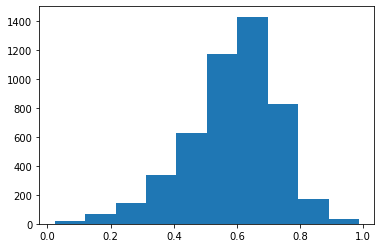

In [ ]:
import matplotlib.pyplot as plt
plt.hist(silver_scores)

In [ ]:
cw = pd.DataFrame(columns=['A', 'B', 'score'])
cw['A'] = questions
cw['B'] = answers
cw['score'] = silver_scores
cw.head() 

,A,B,score
0,gdzie zaobserwowano najmasywniejszą znaną gwia...,Na uzyskanych dzięki niemu zdjęciach można był...,0.499587
1,komu Wasilij Wierieszczagin zadedykował swój o...,"Апофеоз войны, ""Apofieoz wojny"") – obraz Wasil...",0.723198
2,który święty prawosławny został ukazany na obr...,Niestierow pragnął swoimi dziełami oddać hołd ...,0.656832
3,któremu dalajlamie przypisuje się nieśmierteln...,Wśród świeckich tybetańskich rozpowszechnione ...,0.491685
4,jakie były skutki wojny erytrejsko-etiopskiej?,W wyniku działań wojsk etiopskich do przesiedl...,0.432388


In [ ]:
cw.to_csv('/content/drive/MyDrive/czywieszki/czywiesz_sts.csv', index=False)

## Bi-Encoder

In [ ]:
#You can specify any huggingface/transformers pre-trained model here, for example, bert-base-uncased, roberta-base, xlm-roberta-base
model_name = 'paraphrase-xlm-r-multilingual-v1'
batch_size = 16
num_epochs = 5
max_seq_length = 128
use_cuda = torch.cuda.is_available()

In [ ]:
cw = pd.read_csv('/content/drive/MyDrive/czywieszki/czywiesz_sts.csv')
cw.head()

,A,B,score
0,gdzie zaobserwowano najmasywniejszą znaną gwia...,Na uzyskanych dzięki niemu zdjęciach można był...,0.499587
1,komu Wasilij Wierieszczagin zadedykował swój o...,"Апофеоз войны, ""Apofieoz wojny"") – obraz Wasil...",0.723198
2,który święty prawosławny został ukazany na obr...,Niestierow pragnął swoimi dziełami oddać hołd ...,0.656832
3,któremu dalajlamie przypisuje się nieśmierteln...,Wśród świeckich tybetańskich rozpowszechnione ...,0.491685
4,jakie były skutki wojny erytrejsko-etiopskiej?,W wyniku działań wojsk etiopskich do przesiedl...,0.432388


In [ ]:
cds = pd.read_csv('/content/drive/MyDrive/Polish CDSCorpus/dataset.csv', sep='\t')
cds.head()

,ID,A,B,RE,round(RE),A_wrt_B,B_wrt_A
0,1,Zawodnik na boisku ze skórzaną rękawicą robi w...,Mężczyzna w sportowym stroju stoi na ugiętej n...,2.17,2,neutral,neutral
1,2,Zawodnik na boisku ze skórzaną rękawicą robi w...,Wykrok w przód jest robiony na piasku na boisk...,5.00,5,entailment,entailment
2,3,Zawodnik na boisku ze skórzaną rękawicą robi w...,"Mężczyzna w sportowym stroju stoi na nodze, kt...",2.50,3,neutral,neutral
3,4,Zawodnik na boisku ze skórzaną rękawicą robi w...,Chłopak w czerwonych butach stoi na boisku z u...,1.50,2,neutral,neutral
4,5,Zawodnik na boisku ze skórzaną rękawicą robi w...,Osoba wykonuje skok przez przeszkodę na jasnob...,0.00,0,neutral,neutral


In [ ]:
gold_samples = []
for index, row in cds.iterrows():
  score = float(row['RE']) / 5.0
  gold_samples.append(InputExample(texts=[row['A'], row['B']], label=score))

In [ ]:
dev_samples = gold_samples[:1000]
gold_samples = gold_samples[1000:]

In [ ]:
silver_samples = []
for index, row in cw.iterrows():
  score = row['score']
  silver_samples.append(InputExample(texts=[row['A'], row['B']], label=score))

In [ ]:
train_dataloader = DataLoader(gold_samples+silver_samples, shuffle=True, batch_size=batch_size)

In [ ]:
emb_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='cds')

In [ ]:
model = SentenceTransformer(model_name)

2021-01-24 23:26:14 - Load pretrained SentenceTransformer: paraphrase-xlm-r-multilingual-v1
2021-01-24 23:26:14 - Did not find folder paraphrase-xlm-r-multilingual-v1
2021-01-24 23:26:14 - Try to download model from server: https://sbert.net/models/paraphrase-xlm-r-multilingual-v1.zip
2021-01-24 23:26:14 - Load SentenceTransformer from folder: /root/.cache/torch/sentence_transformers/sbert.net_models_paraphrase-xlm-r-multilingual-v1
2021-01-24 23:26:52 - Use pytorch device: cuda


In [ ]:
train_loss = losses.CosineSimilarityLoss(model=model)
warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1) #10% of train data for warm-up
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=emb_evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=bi_encoder_path
          )


2021-01-24 23:33:41 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 0:
2021-01-24 23:33:44 - Cosine-Similarity :	Pearson: 0.9395	Spearman: 0.9385
2021-01-24 23:33:44 - Manhattan-Distance:	Pearson: 0.9215	Spearman: 0.9316
2021-01-24 23:33:44 - Euclidean-Distance:	Pearson: 0.9220	Spearman: 0.9327
2021-01-24 23:33:44 - Dot-Product-Similarity:	Pearson: 0.9252	Spearman: 0.9246
2021-01-24 23:33:44 - Save model to output/bi-encoder/cds_czywiesz_labels-bi-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29



2021-01-24 23:40:35 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 1:
2021-01-24 23:40:39 - Cosine-Similarity :	Pearson: 0.9435	Spearman: 0.9407
2021-01-24 23:40:39 - Manhattan-Distance:	Pearson: 0.9219	Spearman: 0.9342
2021-01-24 23:40:39 - Euclidean-Distance:	Pearson: 0.9228	Spearman: 0.9354
2021-01-24 23:40:39 - Dot-Product-Similarity:	Pearson: 0.9255	Spearman: 0.9243
2021-01-24 23:40:39 - Save model to output/bi-encoder/cds_czywiesz_labels-bi-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29



2021-01-24 23:47:29 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 2:
2021-01-24 23:47:33 - Cosine-Similarity :	Pearson: 0.9434	Spearman: 0.9409
2021-01-24 23:47:33 - Manhattan-Distance:	Pearson: 0.9180	Spearman: 0.9316
2021-01-24 23:47:33 - Euclidean-Distance:	Pearson: 0.9191	Spearman: 0.9332
2021-01-24 23:47:33 - Dot-Product-Similarity:	Pearson: 0.9299	Spearman: 0.9288
2021-01-24 23:47:33 - Save model to output/bi-encoder/cds_czywiesz_labels-bi-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29



2021-01-24 23:54:22 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 3:
2021-01-24 23:54:26 - Cosine-Similarity :	Pearson: 0.9442	Spearman: 0.9417
2021-01-24 23:54:26 - Manhattan-Distance:	Pearson: 0.9185	Spearman: 0.9332
2021-01-24 23:54:26 - Euclidean-Distance:	Pearson: 0.9193	Spearman: 0.9347
2021-01-24 23:54:26 - Dot-Product-Similarity:	Pearson: 0.9295	Spearman: 0.9288
2021-01-24 23:54:26 - Save model to output/bi-encoder/cds_czywiesz_labels-bi-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29



2021-01-25 00:01:17 - EmbeddingSimilarityEvaluator: Evaluating the model on cds dataset after epoch 4:
2021-01-25 00:01:21 - Cosine-Similarity :	Pearson: 0.9447	Spearman: 0.9421
2021-01-25 00:01:21 - Manhattan-Distance:	Pearson: 0.9183	Spearman: 0.9332
2021-01-25 00:01:21 - Euclidean-Distance:	Pearson: 0.9193	Spearman: 0.9348
2021-01-25 00:01:21 - Dot-Product-Similarity:	Pearson: 0.9299	Spearman: 0.9294
2021-01-25 00:01:21 - Save model to output/bi-encoder/cds_czywiesz_labels-bi-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29



In [ ]:
!mkdir /content/drive/MyDrive/models/cds-czywiesz-labels-bi-encoder
!cp -r /content/output/bi-encoder/cds_czywiesz_labels-bi-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29 /content/drive/MyDrive/models/cds-czywiesz-labels-bi-encoder

Evaluate on Information Retrieval

In [12]:
full = pd.read_csv('/content/drive/MyDrive/czywieszki/answers.csv')
full.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
full.head()

,id,url,title,text,question,sentence,answer
0,2070375,http://pl.wikipedia.org/wiki/?curid=2070375,R136a1,R136a1 – gwiazda Wolfa-Rayeta typu widmowego W...,gdzie zaobserwowano najmasywniejszą znaną gwia...,['R136a1 – gwiazda Wolfa-Rayeta typu widmowego...,Na uzyskanych dzięki niemu zdjęciach można był...
1,2070656,http://pl.wikipedia.org/wiki/?curid=2070656,Apoteoza wojny,"Apoteoza wojny (oryg. ros. Апофеоз войны, ""Apo...",komu Wasilij Wierieszczagin zadedykował swój o...,"['Апофеоз войны, ""Apofieoz wojny"") – obraz Was...","Апофеоз войны, ""Apofieoz wojny"") – obraz Wasil..."
2,2070790,http://pl.wikipedia.org/wiki/?curid=2070790,Widzenie chłopca Bartłomieja,"Widzenie chłopca Bartłomieja (oryg. ros. ""Виде...",który święty prawosławny został ukazany na obr...,"['""Видение отроку Варфоломею"") – obraz Michaił...",Niestierow pragnął swoimi dziełami oddać hołd ...
3,2071346,http://pl.wikipedia.org/wiki/?curid=2071346,Cangjang Gjaco,Cangjang Gjaco (tyb. ཚང་དབྱངས་རྒྱ་མཚོ་ Wylie: ...,któremu dalajlamie przypisuje się nieśmierteln...,"['ཚང་དབྱངས་རྒྱ་མཚོ་ Wylie: ""tshang-dbyangs-rgy...",Wśród świeckich tybetańskich rozpowszechnione ...
4,2071390,http://pl.wikipedia.org/wiki/?curid=2071390,Wojna erytrejsko-etiopska,Wojna erytrejsko-etiopska trwała w latach 1998...,jakie były skutki wojny erytrejsko-etiopskiej?,['Wojna erytrejsko-etiopska trwała w latach 19...,W wyniku działań wojsk etiopskich do przesiedl...


Prepare input examples

In [13]:
questions = full['question'].tolist()
answers = full['answer'].tolist()

Divide examples into dev and train sets

In [20]:
model = SentenceTransformer('/content/drive/MyDrive/models/cds-czywiesz-labels-bi-encoder/cds_czywiesz_labels-bi-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29')

2021-01-25 07:52:05 - Load pretrained SentenceTransformer: /content/drive/MyDrive/models/cds-czywiesz-labels-bi-encoder/cds_czywiesz_labels-bi-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29
2021-01-25 07:52:05 - Load SentenceTransformer from folder: /content/drive/MyDrive/models/cds-czywiesz-labels-bi-encoder/cds_czywiesz_labels-bi-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29
2021-01-25 07:52:13 - Use pytorch device: cuda


In [14]:
train_questions, dev_questions = questions[:4000], questions[4000:]
train_answers, dev_answers = answers[:4000], answers[4000:]

In [15]:
dev_queries = {}
dev_corpus = {}
dev_rel_docs = {}

for i in range(len(dev_questions)):
  idx = str(i)
  dev_queries[idx] = dev_questions[i]
  dev_corpus[idx] = dev_answers[i]
  dev_rel_docs[idx] = {idx}

In [16]:
ir_evaluator = evaluation.InformationRetrievalEvaluator(dev_queries, dev_corpus, dev_rel_docs, name='czywiesz')

In [21]:
output_path = '/content/drive/MyDrive/models/cds-czywiesz-labels-bi-encoder/cds_czywiesz_labels-bi-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29/Information-Retrieval_evaluation_czywiesz_results.csv'
model.evaluate(ir_evaluator, output_path=output_path)

2021-01-25 07:52:17 - Information Retrieval Evaluation on czywiesz dataset:
2021-01-25 07:52:21 - Accuracy@1: 82.01%
2021-01-25 07:52:21 - Accuracy@3: 87.76%
2021-01-25 07:52:21 - Accuracy@5: 89.35%
2021-01-25 07:52:21 - Accuracy@10: 91.68%
2021-01-25 07:52:21 - Precision@1: 82.01%
2021-01-25 07:52:21 - Precision@3: 29.25%
2021-01-25 07:52:21 - Precision@5: 17.87%
2021-01-25 07:52:21 - Precision@10: 9.17%
2021-01-25 07:52:21 - Recall@1: 82.01%
2021-01-25 07:52:21 - Recall@3: 87.76%
2021-01-25 07:52:21 - Recall@5: 89.35%
2021-01-25 07:52:21 - Recall@10: 91.68%
2021-01-25 07:52:21 - MRR@10: 0.8526
2021-01-25 07:52:21 - NDCG@10: 0.8681
2021-01-25 07:52:21 - MAP@100: 0.8543
2021-01-25 07:52:21 - Queries: 817
2021-01-25 07:52:21 - Corpus: 817



0.8542713814021549

In [22]:
results = pd.read_csv('/content/drive/MyDrive/models/cds-czywiesz-labels-bi-encoder/cds_czywiesz_labels-bi-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29/similarity_evaluation_cds_results.csv')
results

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,-1,0.939529,0.938488,0.922024,0.932723,0.921453,0.931622,0.925220,0.924558
1,1,-1,0.943479,0.940721,0.922770,0.935424,0.921906,0.934204,0.925533,0.924305
2,2,-1,0.943445,0.940915,0.919063,0.933215,0.918023,0.931593,0.929880,0.928767
3,3,-1,0.944208,0.941721,0.919334,0.934654,0.918480,0.933238,0.929471,0.928849
4,4,-1,0.944674,0.942114,0.919317,0.934806,0.918335,0.933238,0.929866,0.929383


Final results

In [23]:
results = pd.read_csv('/content/drive/MyDrive/models/cds-czywiesz-labels-bi-encoder/cds_czywiesz_labels-bi-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29/similarity_evaluation_cds_results.csv')
results

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,-1,0.939529,0.938488,0.922024,0.932723,0.921453,0.931622,0.925220,0.924558
1,1,-1,0.943479,0.940721,0.922770,0.935424,0.921906,0.934204,0.925533,0.924305
2,2,-1,0.943445,0.940915,0.919063,0.933215,0.918023,0.931593,0.929880,0.928767
3,3,-1,0.944208,0.941721,0.919334,0.934654,0.918480,0.933238,0.929471,0.928849
4,4,-1,0.944674,0.942114,0.919317,0.934806,0.918335,0.933238,0.929866,0.929383


In [25]:
results = pd.read_csv('/content/drive/MyDrive/models/cds-czywiesz-labels-bi-encoder/cds_czywiesz_labels-bi-encoder-bert-base-multilingual-cased-2021-01-24_22-52-29/Information-Retrieval_evaluation_czywiesz_results.csv/Information-Retrieval_evaluation_czywiesz_results.csv')
results

,epoch,steps,Accuracy@1,Accuracy@3,Accuracy@5,Accuracy@10,Precision@1,Recall@1,Precision@3,Recall@3,Precision@5,Recall@5,Precision@10,Recall@10,MRR@10,NDCG@10,MAP@100
0,-1,-1,0.820073,0.877601,0.893513,0.916769,0.820073,0.820073,0.292534,0.877601,0.178703,0.893513,0.091677,0.916769,0.852552,0.86812,0.854271
1,-1,-1,0.820073,0.877601,0.893513,0.916769,0.820073,0.820073,0.292534,0.877601,0.178703,0.893513,0.091677,0.916769,0.852552,0.86812,0.854271
